# Final Exam (part 3) - Computational Physics I

### Deadline: Friday 13 December 2024 (by 17h00)
### Credits: 10 points

### Please keep the structure provided below and submit an organised notebook with clear answers to each item.

## Name:

## 3. Fourier analysis: removing Herringbone MRI artifacts

This problem consist of using Fourier analysis to remove undesired Herringbone artifacts from magnetic resonance images (MRI).

The file provided below **herringbone-mri-artifact.jpg** contains a brain MRI image affected by the Herringbone artifact. This artifact can be produced by electromagnetic spikes by gradient coils, a fluctuating power supply, or radiofrequency pulse discrepancies during MRI scanning. In real space, the regularly spaced stripes resemble the appearance of a fabric with a herringbone pattern (which gives the artifact its name). In this image, the artifact covers the entire image with multiple diagonal stripes, which would be seen as spike artifacts in Fourier space. Your task is to remove them.

#### Download the image file:
https://github.com/wbandabarragan/physics-teaching-data/blob/main/2D-data/herringbone-mri-artifact.jpg

#### Reference:
Case courtesy of Frank Gaillard, <a href="https://radiopaedia.org/?lang=us">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/19695?lang=us">rID: 19695</a>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots 
from PIL import Image

In [2]:
# set plot style
plt.style.use(['science', 'notebook', 'no-latex'])

#### Image I/O:

(a) Inspect the file. Then, write a python function that reads the data from the **herringbone-mri-artifact.jpg** file, and returns its 3 layers (channels) as numpy arrays.

In [3]:
# Create a function to read the image
def ReadImageFile(image_path, channel):
    """
    Function to read an image, choose one of its channels,
    plot the image and return the image as a numpy array.

    Arguments:
            - image_path (str) : path to the image file
            - channel (int)    : channel to choose from the image

    Returns:    
                image: (numpy array) - image as a numpy array
    """

    # Read the image
    image = Image.open(image_path)

    # Choose the channel
    image = image.getchannel(channel)

    return np.array(image)

(b) Call your function, select a single channel and make a map of it. Identify and label the Herringbone artifacts on the image using small arrows.

In [5]:
# define the image path
image_path = "./herringbone-mri-artifact.jpg"

# read the image
image = ReadImageFile(image_path, 0)

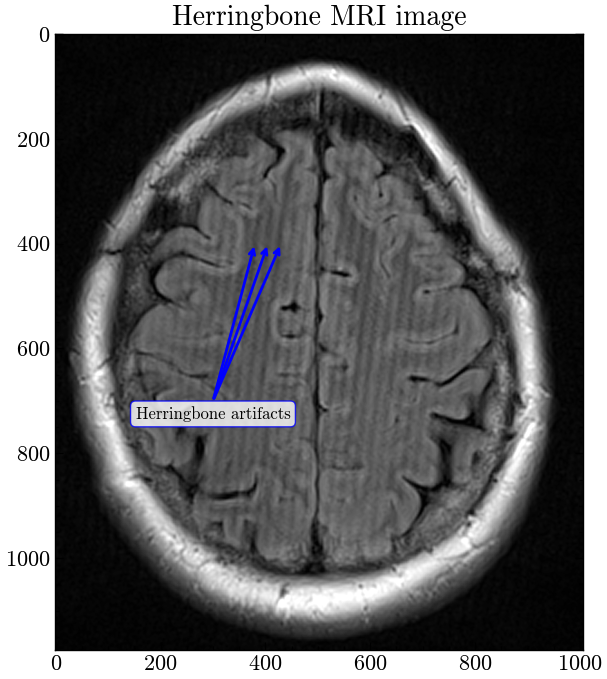

In [20]:
# plot the image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
ax.set_title("Herringbone MRI image", fontsize = 20)
# Identify the artifacts in the image
# I will add three arrows in the image to point to the artifacts
ax.annotate(
    "",
    xy=(405, 400), xytext=(300, 700),
    arrowprops = dict(arrowstyle = "->", color = "blue", lw = 2))
ax.annotate(
    "",
    xy=(430, 400), xytext=(300, 700),
    arrowprops = dict(arrowstyle = "->", color = "blue", lw = 2))

ax.annotate(
    "",
    xy=(380, 400), xytext=(300, 700),
    arrowprops = dict(arrowstyle = "->", color = "blue", lw = 2))

ax.text(
    300, 740, "Herringbone artifacts", fontsize=12, color="black", ha="center", va="bottom",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="white", alpha=0.8)
)


plt.show()
plt.close()

#### 2D Fourier transform:

(c) Create a function that Fourier transforms this image and returns the Fourier image and the correct frequencies.

In [21]:
# Create a function to compute the FFT of the image
def FFT(image):
    """
    Function to compute the Fast Fourier Transform (FFT) of an image.

    Arguments:
            - image(numpy array)      : image as a numpy array

    Returns:    
            - fft_image (numpy array) : FFT of the image
    """

    # Compute the FFT of the image
    fft_image = np.fft.fft2(image)

    # Shift the zero frequency component to the center
    shift_fft_image = np.fft.fftshift(fft_image)

    # Compute the magnitude of the FFT
    magnitude_spectrum = np.abs(shift_fft_image)
    
    return fft_image, shift_fft_image, magnitude_spectrum


(d) Call your function in (c), and make a two-panel figure with the original image on the left and a labeled 2D plot of its Fourier image on the right. Identify and label the Herringbone artifacts on the Fourier image.

In [22]:
# Compute the FFT of the image
fft_image, shift_fft_image, magnitude_spectrum = FFT(image)

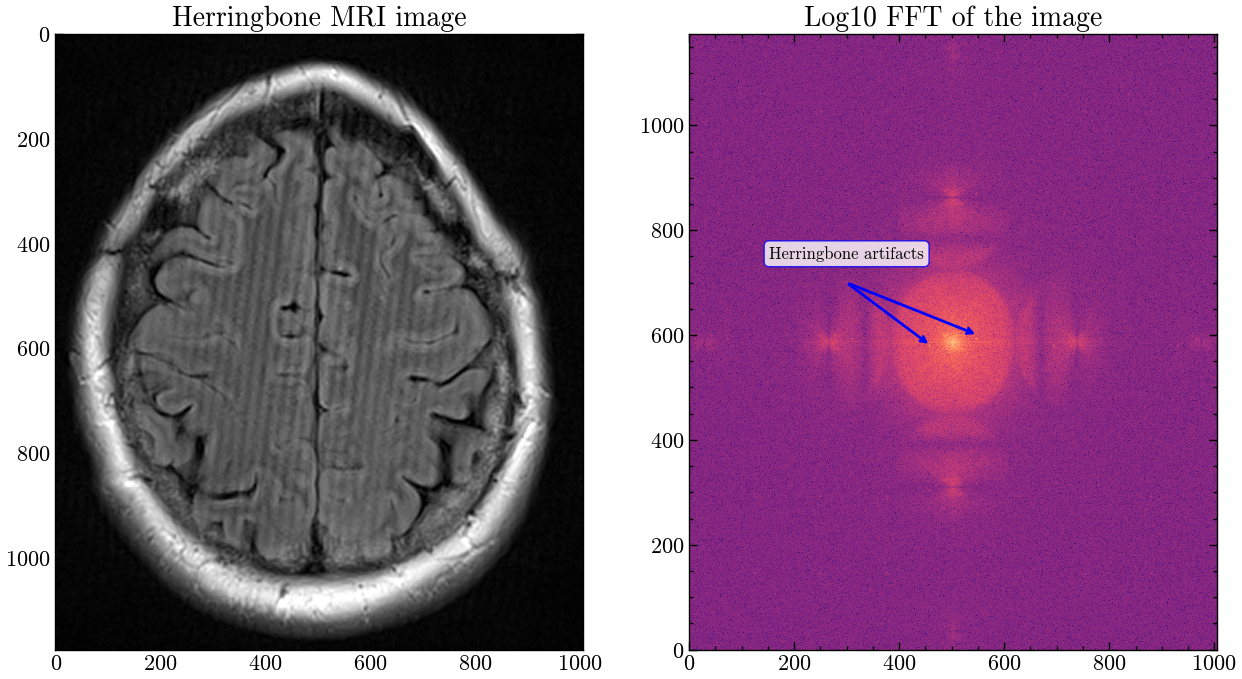

In [23]:
# Plot the original image and its FFT
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Herringbone MRI image", fontsize = 20)

ax[1].pcolor(np.log10(magnitude_spectrum),
                       shading = 'auto',cmap='magma')
ax[1].set_title("Log10 FFT of the image", fontsize = 20)
# Identify the artifacts in the FFT
ax[1].annotate(
    "",
    xy=(460, 580), xytext=(300, 700),
    arrowprops = dict(arrowstyle = "->", color = "blue", lw = 2))
ax[1].annotate(
    "",
    xy=(550, 600), xytext=(300, 700),
    arrowprops = dict(arrowstyle = "->", color = "blue", lw = 2))

ax[1].text(
    300, 740, "Herringbone artifacts", fontsize=12, color="black", ha="center", va="bottom",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="white", alpha=0.8)
)

plt.show()
plt.close()

(e) Briefly comment, how do the image artifacts look in Fourier space? 

The Herringbone artifacts are seen as spikes in Fourier space. They are symmetrically distributed around the origin, offset diagonally from the x and y axes. The spikes are the result of the regular spacing of the stripes in real space, and their offset from the axes is due to the diagonal orientation of the stripes.
https://www.ajronline.org/doi/10.2214/AJR.07.2874

#### Masking and filtering:

(f) Create an appropriate mask for the Fourier image that matches the features associated with the Herringbone artifacts. Plot the mask.

I will first try to remove the two main diagonal spikes in Fourier space, and see how the image looks after that. If the image still has artifacts, I will try to remove the other spikes located upwards, downwards, and to the sides of the main diagonal spikes.

In [25]:
def MaskFunction(image, show = False):
    """
    Function to create a mask for the FFT image.

    Arguments:
            - image (numpy array) : image as a numpy array

    Returns:    
            - mask (numpy array)  : mask for the FFT image
    """

    # Create a mask for the FFT image
    mask = np.ones(image.shape)
    print(mask.shape)

    # Set the center of the mask to 1
        # The mask must be in along the x-axis in the centre
    # Avoiding the frequencies at centre
    centers = [
        (mask.shape[0] // 2 - 10, mask.shape[1] // 2 - 45), # circle 1 (y1, x1)
        (mask.shape[0] // 2 + 10, mask.shape[1] // 2 + 45)] # circle 2 (y2, x2)
    
    radius = 7

    Y, X = np.meshgrid(np.arange(mask.shape[1]), np.arange(mask.shape[0]))
   
    for cx, cy in centers:
        distance_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
        mask[distance_from_center < radius] = 0

    # Plot the mask if show is True
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(mask, cmap='gray')
        ax.set_title("Mask for the FFT image", fontsize = 20)
        ax.invert_yaxis()
        plt.show()
        plt.close()
   
    return mask

(1175, 1006)


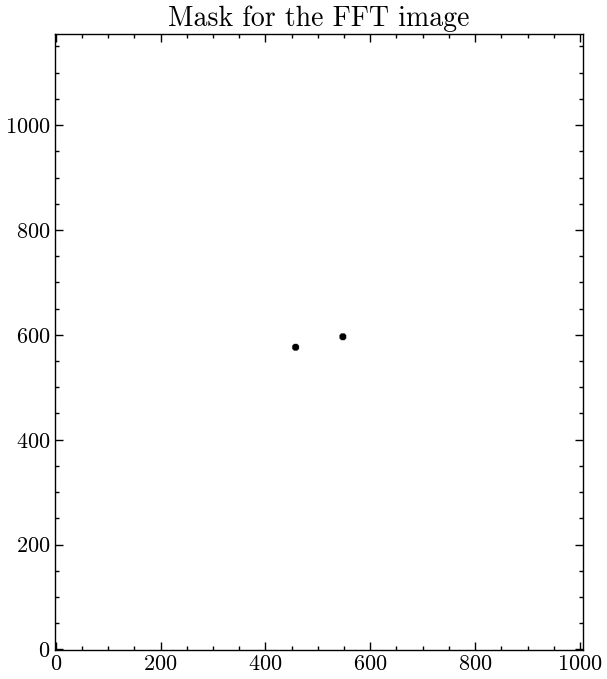

In [26]:
# Create a mask for the FFT image
mask = MaskFunction(magnitude_spectrum, show=True)

(g) Use your mask from (f) to remove the Herringbone artifacts from the Fourier image.

In [27]:
# Apply the mask to the FFT image
def fttMaskImage(magnitude_spectrum, shift_fft_image):
    """
    Function to apply a mask to the FFT image.

    Arguments:
            - magnitude_spectrum (numpy array) : magnitude of the FFT image
            - shift_fft_image (numpy array)    : shifted FFT image

    Returns:
            - masked_fft_image (numpy array)   : masked FFT image
    """

    # Apply the mask to the FFT image
    masked_fft_image = shift_fft_image * mask

    # Compute the magnitude of the masked FFT image
    magnitude_masked_fft_image = np.abs(masked_fft_image)

    # Make the two-panel plot of the FFT image and its masked version
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].pcolor(np.log10(magnitude_spectrum), shading='auto', cmap='magma')
    ax[0].set_title('FFT of the Image', fontsize = 20)

    ax[1].pcolor(np.log10(magnitude_masked_fft_image), shading='auto', cmap='magma')
    ax[1].set_title('Masked FFT of the Image', fontsize = 20)
    plt.show()

    return masked_fft_image

/tmp/ipykernel_673094/4076295002.py:25: RuntimeWarning: divide by zero encountered in log10
  ax[1].pcolor(np.log10(magnitude_masked_fft_image), shading='auto', cmap='magma')


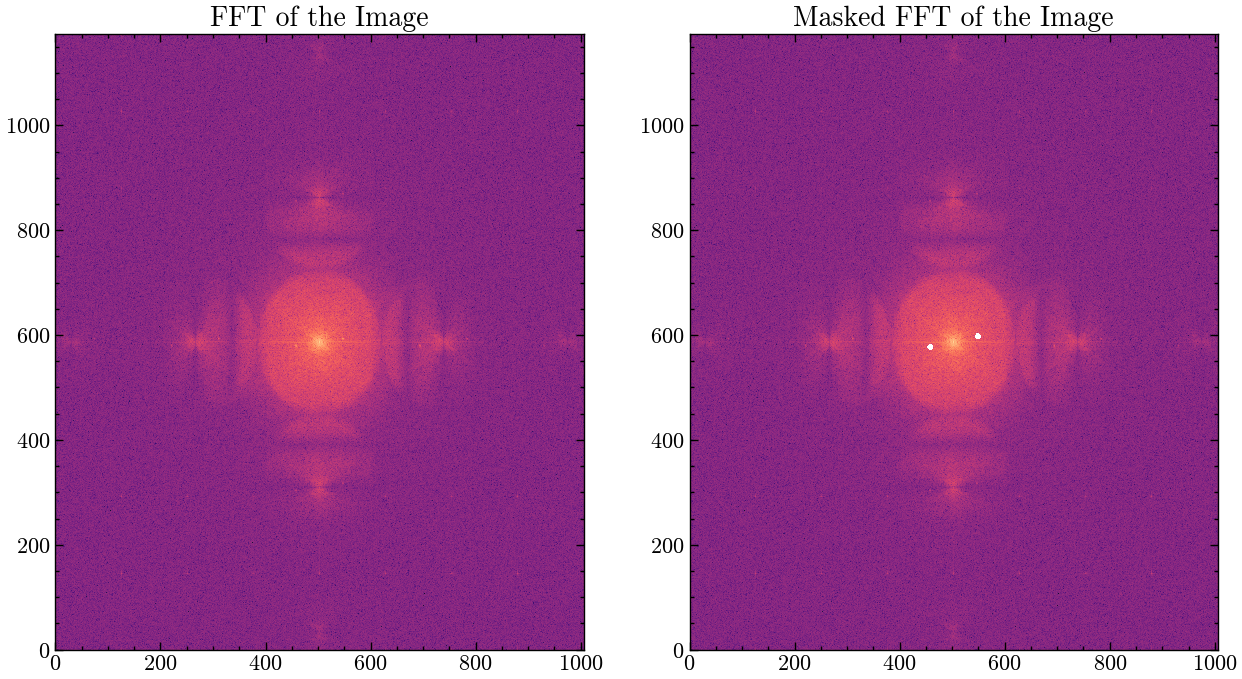

In [28]:
# Apply the mask to the FFT image
masked_fft_image = fttMaskImage(magnitude_spectrum, shift_fft_image)

(h) Inverse Fourier transform the masked Fourier image and make a two-panel figure showing the original image on the left and the new filtered image (without the Herringbone artifacts) on the right.

In [29]:
# Apply the mask to the FFT image
masked_fft_image = shift_fft_image * mask

# Perform the inverse FFT
channel_0_reconstructed = np.abs(np.fft.ifft2(np.fft.ifftshift(masked_fft_image)))

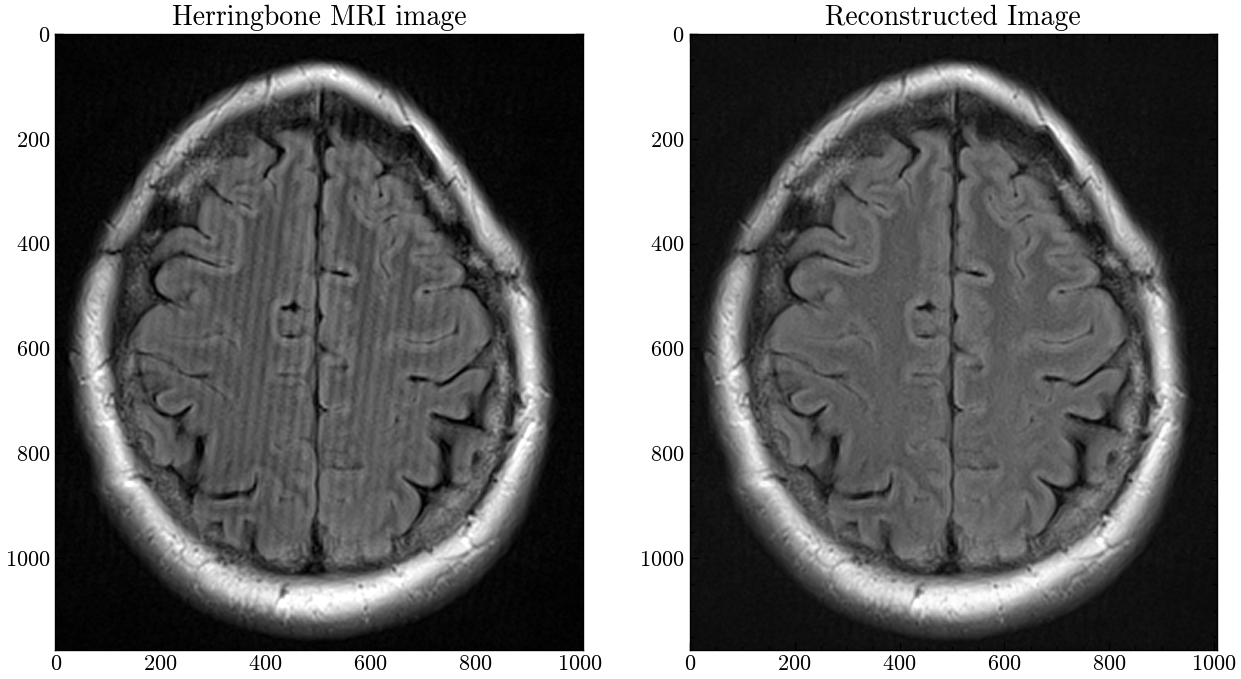

In [30]:
# Plot the original and reconstructed images
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Herringbone MRI image', fontsize = 20)

ax[1].imshow(channel_0_reconstructed, cmap='gray')
ax[1].set_title("Reconstructed Image", fontsize = 20)

plt.show()
plt.close()

#### Artifact-free image:

(i) Create a function that combines all the previous steps. The function should receive an input image channel, apply the Fourier filter to it and return the original and the filtered channel images. Call and apply your filter function to the other two channels of the **herringbone-mri-artifact.jpg** image.

In [32]:
def HerringboneFilter(image_path, channel, show = False):

    # Read the image
    image = ReadImageFile(image_path, channel)

    # Compute the FFT of the image
    fft_image, shift_fft_image, magnitude_spectrum = FFT(image)

    # Create a mask for the FFT image
    mask = MaskFunction(magnitude_spectrum, show = False)

    # Apply the mask to the FFT image   
    masked_fft_image = shift_fft_image * mask

    # Perform the inverse FFT
    image_reconstructed = np.fft.ifft2(np.fft.ifftshift(masked_fft_image))

    # Plot the original and reconstructed channels images
    if show:
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(f"Herringbone MRI image (Channel {channel})", fontsize = 20)

        ax[1].imshow(np.abs(image_reconstructed), cmap='gray')
        ax[1].set_title(f"Reconstructed Image (Channel {channel})", fontsize = 20)

        plt.show()
        plt.close()

    return np.abs(image_reconstructed)

(1175, 1006)


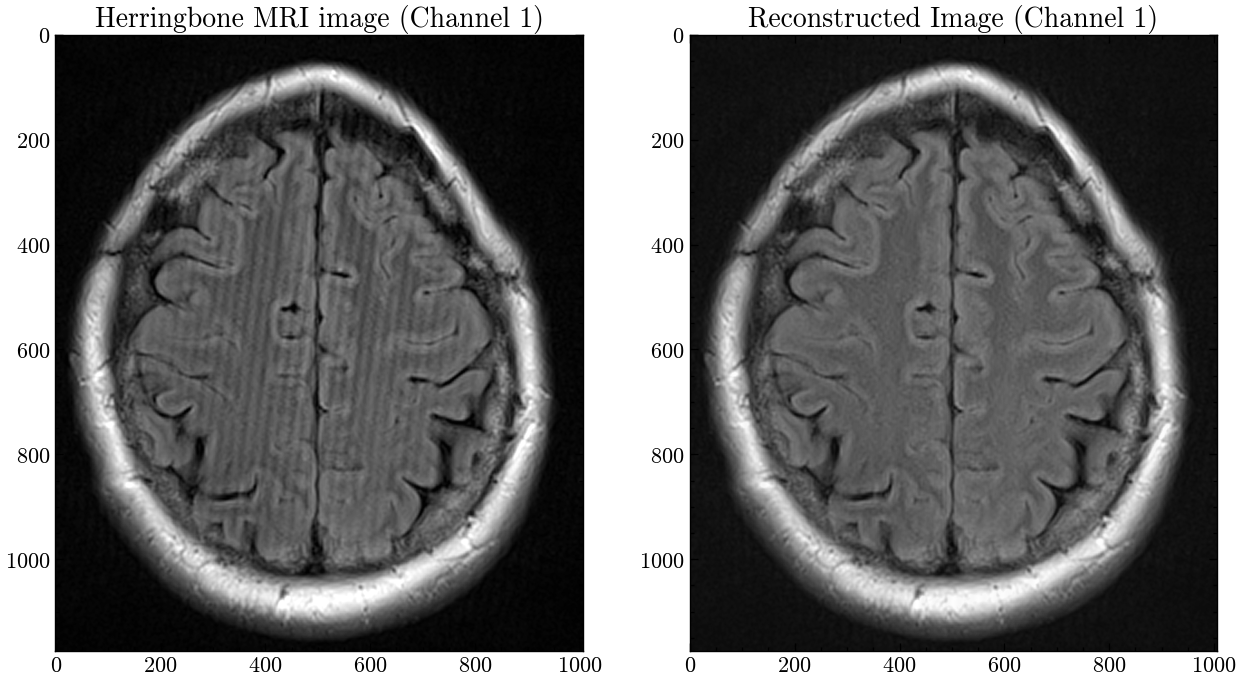

In [33]:
# Apply the Herringbone filter to the other channels
channel_1_reconstructed = HerringboneFilter(image_path, 1, show = True)

(1175, 1006)


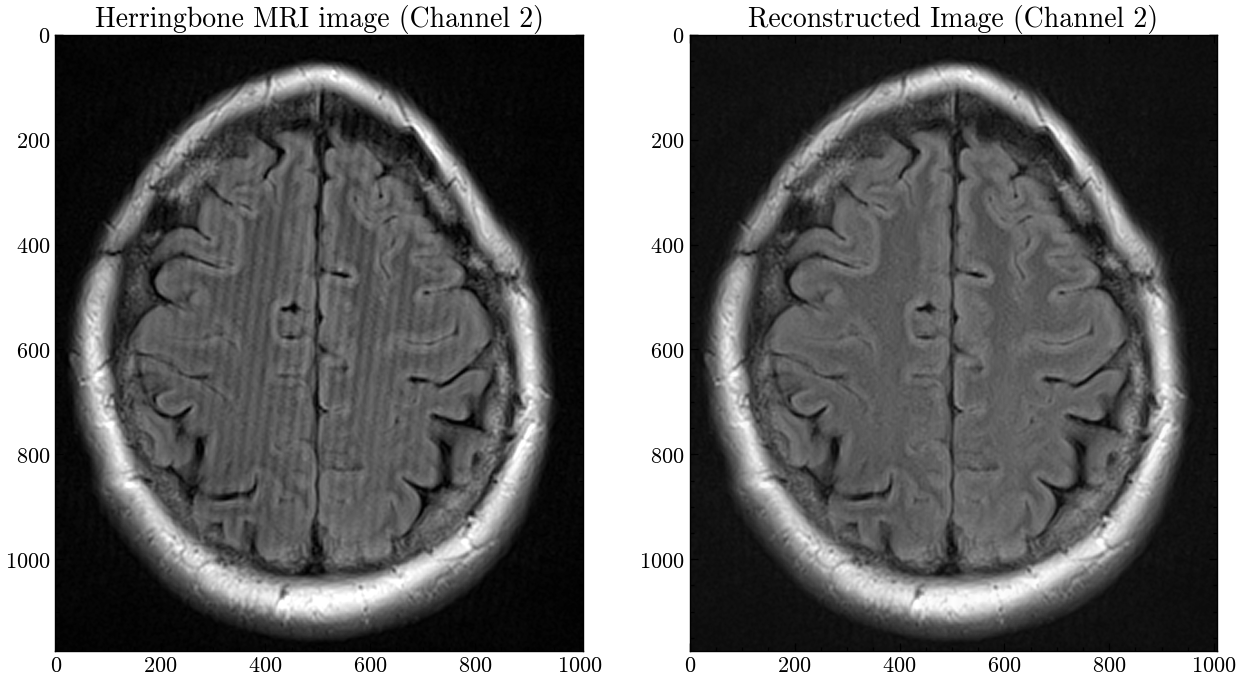

In [34]:
channel_2_reconstructed = HerringboneFilter(image_path, 2, show = True)

(j) Using the output clean images from (i), reconstruct the 3-layered image and make a two panel figure showing the original 3-layered image and your new artifact-free 3-layered image. Briefly comment on your results.

In [35]:
# Reconstruction of the image using all the channels
processed_image = np.zeros((channel_0_reconstructed.shape[0], channel_0_reconstructed.shape[1], 3), dtype= int)
processed_image[:, :, 0] = channel_0_reconstructed
processed_image[:, :, 1] = channel_1_reconstructed
processed_image[:, :, 2] = channel_2_reconstructed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3..260].


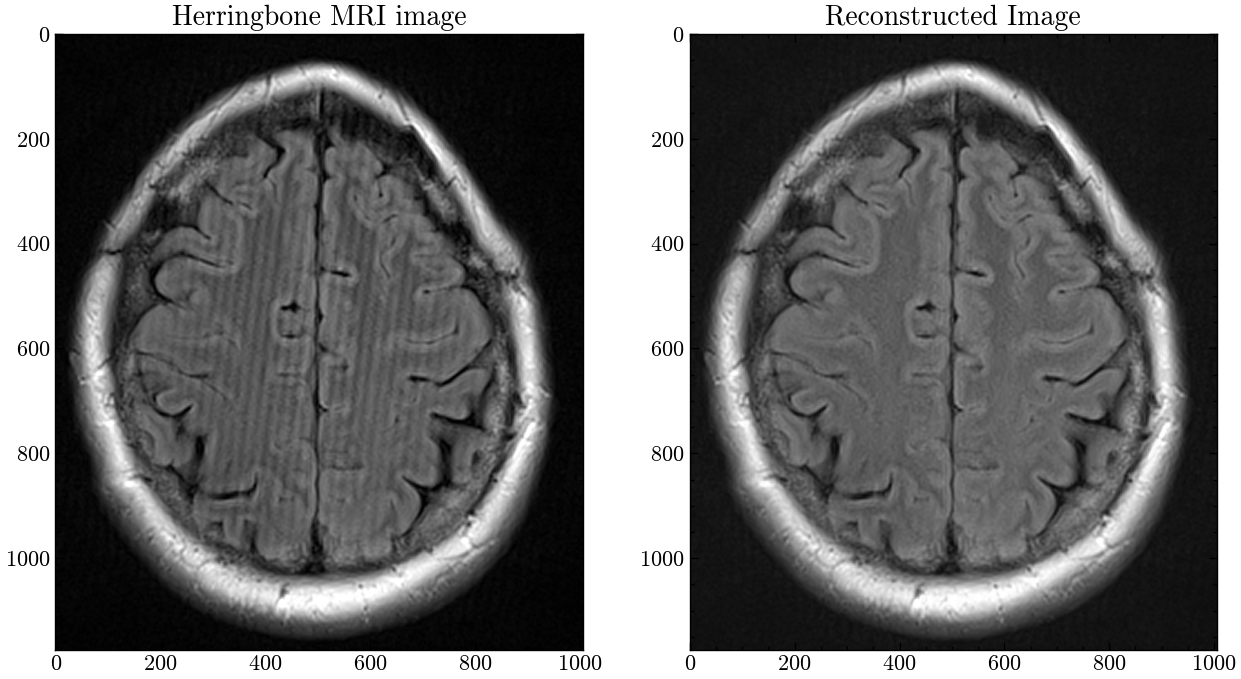

In [36]:
# Plot the original and reconstructed images
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Herringbone MRI image', fontsize = 20)

ax[1].imshow(processed_image, cmap='gray')
ax[1].set_title("Reconstructed Image", fontsize = 20)

plt.show()
plt.close()

By just removing the two main diagonal spikes in Fourier space, we have successfully removed the Herringbone artifacts from the MRI image. What we could do next is to try removing the aforementioned spikes located upwards, downwards, and to the sides of the main diagonal spikes. However, it seems not to be necessary in this case. On the other hand, we could also use a peak detection algorithm to automatically identify the spikes in Fourier space, thereby getting the exact coordinates of the spikes to create the mask. 

Source: https://www.ajer.org/papers/v5%2805%29/Z050501840189.pdf